In [4]:
import sys
!{sys.executable} -m pip install autogluon.timeseries

  Using cached gluonts-0.15.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached boto3-1.35.56-py3-none-any.whl.metadata (6.7 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached window_ops-0.0.15-py3-none-any.whl.metadata (6.8 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached botocore-1.35.56-py3-none-any.whl.metadata (5.7 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.3-py3-none-any.whl.metadata (1.7 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9

In [1]:
import torch
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of GPUs available: 1
GPU 0: NVIDIA A30


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd
import numpy as np

/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [46]:
my_data = pd.read_csv('../California-data-set/median_311903.csv', index_col=0, parse_dates=True)
my_data = my_data.sort_values(by='time.1')
my_data

,time.1,id,direction,type,percentage,flow
time,,,,,,
2018-01-01 00:00:00,01/01/2018 00:00:00,311903,E,ML,100,904
2018-01-01 01:00:00,01/01/2018 01:00:00,311903,E,ML,100,814
2018-01-01 02:00:00,01/01/2018 02:00:00,311903,E,ML,100,649
2018-01-01 03:00:00,01/01/2018 03:00:00,311903,E,ML,100,489
2018-01-01 04:00:00,01/01/2018 04:00:00,311903,E,ML,92,404
...,...,...,...,...,...,...
2018-12-31 19:00:00,12/31/2018 19:00:00,311903,E,ML,100,2145
2018-12-31 20:00:00,12/31/2018 20:00:00,311903,E,ML,100,1858
2018-12-31 21:00:00,12/31/2018 21:00:00,311903,E,ML,100,1980


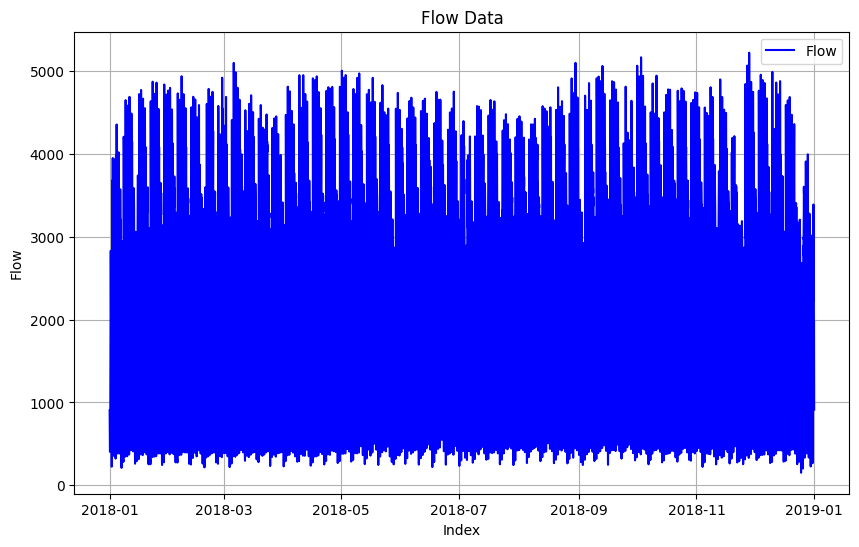

In [47]:
import matplotlib.pyplot as plt

# Assuming the dataframe df is already created and has the 'flow' column
# Example: df = pd.DataFrame({'flow': [67.0, 66.8, 68.3, ...]})

# Plotting the flow column
plt.figure(figsize=(10, 6))
plt.plot(my_data['flow'], label='Flow', color='blue')
plt.title('Flow Data')
plt.xlabel('Index')
plt.ylabel('Flow')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
def create_sequences(data, input_length, forecast_horizon):
    """
    Creates sequences for time series data, excluding any sequences containing NaN values.

    Parameters:
    - data: pandas DataFrame containing the data. Must include the 'flow' column.
    - input_length: int, number of past time steps to include in each input sequence.
    - forecast_horizon: int, number of future steps to predict.

    Returns:
    - sequences_df: pandas DataFrame containing all sequences with input lags and output leads,
                    and an 'item_id' column to separate each sequence, including timestamps.
    """
    sequences = []
    item_id = 0  # To assign unique ID to each sequence

    for i in range(input_length, len(data) - forecast_horizon + 1):
        # Extract the input sequence
        X_seq = data.iloc[i - input_length:i]['flow'].values
        X_timestamps = data.iloc[i - input_length:i].index
        # Extract the target sequence
        y_seq = data.iloc[i:i + forecast_horizon]['flow'].values
        y_timestamps = data.iloc[i:i + forecast_horizon].index

        # Check for NaN values in the input sequence and target sequence
        if not np.isnan(X_seq).any() and not np.isnan(y_seq).any():
            # Convert X_seq and y_seq to DataFrames, including their timestamps
            x_df = pd.DataFrame({'target': X_seq, 'timestamp': X_timestamps})
            y_df = pd.DataFrame({'target': y_seq, 'timestamp': y_timestamps})

            # Concatenate X_df and y_df
            seq_df = pd.concat([x_df, y_df], ignore_index=True)

            # Add 'item_id' column
            seq_df['item_id'] = str(item_id)
            item_id += 1  # Increment item_id

            # Append to list
            sequences.append(seq_df)
        else:
            # Optionally, log or count the skipped sequences
            pass  # Simply skip sequences with NaNs

    # Concatenate all sequences into one DataFrame
    sequences_df = pd.concat(sequences)
    sequences_df['item_id'] = sequences_df['item_id'].astype('str')
    sequences_df['target'] = sequences_df['target'].astype('float32')

    return sequences_df

In [49]:
input_lengths = [24 * i for i in range(1, 22)]
prediction_length = 6

In [50]:
from collections import defaultdict
data_dict = defaultdict(dict)

for length in input_lengths:
    print(f"Processing input length: {length}")

    # Create sequences with forecast_horizon=6
    test = create_sequences(my_data, length, forecast_horizon=6)

    # Store in the dictionary
    data_dict[length]['test'] = test

    # Print shapes and ensure no NaNs
    print(f"  test shape: {test.index.max()+1}, {len(test.item_id.unique())}\n")

Processing input length: 24
  test shape: 30, 8730

Processing input length: 48
  test shape: 54, 8706

Processing input length: 72
  test shape: 78, 8682

Processing input length: 96
  test shape: 102, 8658

Processing input length: 120
  test shape: 126, 8634

Processing input length: 144
  test shape: 150, 8610

Processing input length: 168
  test shape: 174, 8586

Processing input length: 192
  test shape: 198, 8562

Processing input length: 216
  test shape: 222, 8538

Processing input length: 240
  test shape: 246, 8514

Processing input length: 264
  test shape: 270, 8490

Processing input length: 288
  test shape: 294, 8466

Processing input length: 312
  test shape: 318, 8442

Processing input length: 336
  test shape: 342, 8418

Processing input length: 360
  test shape: 366, 8394

Processing input length: 384
  test shape: 390, 8370

Processing input length: 408
  test shape: 414, 8346

Processing input length: 432
  test shape: 438, 8322

Processing input length: 456
  test

# Zero-shot

In [51]:
import time

In [52]:
def chronos_zero_shot(input_lengths, prediction_length, model_type):
    results_dict = defaultdict(dict)
    inference_results = []

    for length in input_lengths:
        logging.info(f"Processing input length: {length}")

        # prepare the data
        test_data = TimeSeriesDataFrame(data_dict[length]['test'])
        test_data_ready, test_data = test_data.train_test_split(prediction_length)

        predictor = TimeSeriesPredictor(prediction_length=prediction_length,verbosity=2).fit(test_data_ready, presets=model_type)
        
        # Record start time
        start_time = time.time()
        
        predictions = predictor.predict(test_data_ready)
        
        # Record end time and compute the inference time
        inference_time = time.time() - start_time
        logging.info(f"\nInference time: {inference_time:.6f} seconds")
        
        ground_truth_df = test_data.groupby(level='item_id').tail(6)
        predicted_df = predictions[['mean']]

        results_dict[length]['Predicted_Results'] = predicted_df
        results_dict[length]['Gound_Truth'] = ground_truth_df

        inference_results.append({
            "length": length,
            "inference_time": inference_time
        })

    # Convert the results into a DataFrame
    df_inference = pd.DataFrame(inference_results)
    logging.info(f"{model_type}")
    logging.info("\n" + df_inference.to_string(index=False))

    return results_dict

In [44]:
torch.cuda.empty_cache()

In [53]:
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level to INFO
    format='%(asctime)s - %(message)s',  # Customize the log message format
    handlers=[
        logging.FileHandler('chronos-pems.log'),  # Log messages to 'output.log'
        logging.StreamHandler()             # Also output to console/notebook
    ]
)

In [56]:
# results_dict1 = chronos_zero_shot(input_lengths, prediction_length, "chronos_tiny")
results_dict2 = chronos_zero_shot(input_lengths, prediction_length, "chronos_mini")
# results_dict3 = chronos_zero_shot(input_lengths, prediction_length, "chronos_small")
# results_dict4 = chronos_zero_shot(input_lengths, prediction_length, "chronos_base")
# results_dict5 = chronos_zero_shot(input_lengths, prediction_length, "chronos_large")

2025-03-21 17:23:05,595 - Processing input length: 24
No path specified. Models will be saved in: "AutogluonModels/ag-20250321_172305"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20250321_172305'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.19
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #25-Ubuntu SMP Wed Jan 15 20:45:09 UTC 2025
CPU Count:          16
GPU Count:          1
Memory Avail:       107.46 GB / 125.71 GB (85.5%)
Disk Space Avail:   377.82 GB / 1003.85 GB (37.6%)
Setting presets to: chronos_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selec

In [ ]:
results_dict3 = chronos_zero_shot(input_lengths, prediction_length, "chronos_small")
results_dict4 = chronos_zero_shot(input_lengths, prediction_length, "chronos_base")
results_dict5 = chronos_zero_shot(input_lengths, prediction_length, "chronos_large")

2025-03-21 17:46:33,933 - Processing input length: 24
No path specified. Models will be saved in: "AutogluonModels/ag-20250321_174634"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20250321_174634'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.19
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #25-Ubuntu SMP Wed Jan 15 20:45:09 UTC 2025
CPU Count:          16
GPU Count:          1
Memory Avail:       107.01 GB / 125.71 GB (85.1%)
Disk Space Avail:   377.19 GB / 1003.85 GB (37.6%)
Setting presets to: chronos_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

In [37]:
def cal_metrics(df_true, df_pred):
    df_merged = pd.merge(df_true, df_pred, on=['item_id', 'timestamp'], how='inner')

    # Step 3: Assign prediction step numbers (1 to 6) within each 'item_id'
    df_merged['step'] = df_merged.groupby('item_id').cumcount() + 1

    # Step 4: Calculate error metrics
    df_merged['error'] = df_merged['mean'] - df_merged['target']
    df_merged['abs_error'] = df_merged['error'].abs()
    df_merged['squared_error'] = df_merged['error'] ** 2

    # Handle division by zero in MAPE calculation by adding a very small number (epsilon)
    epsilon = 1e-10
    df_merged['abs_percentage_error'] = df_merged['abs_error'] / (df_merged['target'].abs() + epsilon)

    # Step 5: Calculate overall metrics
    overall_mse = df_merged['squared_error'].mean()
    overall_rmse = np.sqrt(overall_mse)
    overall_mae = df_merged['abs_error'].mean()
    overall_mape = df_merged['abs_percentage_error'].mean() * 100

    print("Overall Evaluation Metrics:")
    print(f"MSE: {overall_mse:.4f}")
    print(f"RMSE: {overall_rmse:.4f}")
    print(f"MAE: {overall_mae:.4f}")
    print(f"MAPE: {overall_mape:.2f}%")

    # Step 6: Calculate metrics for each prediction step
    metrics_by_step = df_merged.groupby('step').agg({
      'squared_error': 'mean',
      'abs_error': 'mean',
      'abs_percentage_error': 'mean'
    }).reset_index()

    metrics_by_step['MSE'] = metrics_by_step['squared_error']
    metrics_by_step['RMSE'] = np.sqrt(metrics_by_step['squared_error'])
    metrics_by_step['MAE'] = metrics_by_step['abs_error']
    metrics_by_step['MAPE'] = metrics_by_step['abs_percentage_error'] * 100

    # Select relevant columns and round for better readability
    metrics_by_step = metrics_by_step[['step', 'MSE', 'RMSE', 'MAE', 'MAPE']]

    return metrics_by_step

In [38]:
def metrics_results(results_dict):
    for length in input_lengths:
        print(f"Processing input length: {length}")
    
        predict = results_dict[length]['Predicted_Results']
        truth = results_dict[length]['Gound_Truth']
        evaluation_df = cal_metrics(predict, truth)
        display(evaluation_df)

In [55]:
metrics_results(results_dict1)

Processing input length: 24
Overall Evaluation Metrics:
MSE: 417317.4155
RMSE: 646.0011
MAE: 409.9529
MAPE: 21.20%


,step,MSE,RMSE,MAE,MAPE
0,1,161990.244029,402.480116,267.634685,13.246038
1,2,345795.238948,588.043569,386.021875,18.875946
2,3,514738.229780,717.452598,435.448481,21.173207
3,4,537479.280522,733.129784,457.882640,23.035234
4,5,487875.047090,698.480527,462.881637,24.992415
5,6,456053.074790,675.317018,449.875619,25.866203


Processing input length: 48
Overall Evaluation Metrics:
MSE: 205067.8653
RMSE: 452.8442
MAE: 272.8981
MAPE: 14.53%


,step,MSE,RMSE,MAE,MAPE
0,1,90129.609247,300.215938,186.765198,9.732028
1,2,164384.536548,405.443629,249.677045,13.291529
2,3,210727.061204,459.050173,281.622680,14.984930
3,4,249846.569785,499.846546,302.410568,15.919508
4,5,262335.437495,512.186917,311.615587,16.619682
5,6,253017.022936,503.007975,305.320095,16.637461


Processing input length: 72
Overall Evaluation Metrics:
MSE: 155204.6626
RMSE: 393.9602
MAE: 248.4669
MAPE: 13.37%


,step,MSE,RMSE,MAE,MAPE
0,1,72121.141543,268.553796,173.985434,9.252062
1,2,131010.643371,361.953924,233.214060,12.538157
2,3,163953.368468,404.911556,258.682321,13.924253
3,4,189530.913860,435.351483,274.612361,14.665935
4,5,193499.523575,439.885807,279.154485,15.025081
5,6,181130.301623,425.594057,271.168228,14.835763


Processing input length: 96
Overall Evaluation Metrics:
MSE: 120324.0176
RMSE: 346.8775
MAE: 223.1351
MAPE: 12.32%


,step,MSE,RMSE,MAE,MAPE
0,1,55713.413606,236.036890,160.220456,8.640634
1,2,95980.985937,309.807982,208.525437,11.581953
2,3,119751.161827,346.050808,229.028412,12.650719
3,4,146675.933603,382.982942,243.712484,13.421241
4,5,153591.719560,391.907795,249.321548,13.770696
5,6,150251.630889,387.623053,248.019641,13.854033


Processing input length: 120
Overall Evaluation Metrics:
MSE: 106989.7891
RMSE: 327.0929
MAE: 210.5865
MAPE: 11.73%


,step,MSE,RMSE,MAE,MAPE
0,1,49863.171445,223.300630,153.596419,8.303001
1,2,85377.407534,292.194126,196.788693,10.880368
2,3,105738.706285,325.174886,214.997127,11.960686
3,4,124639.673820,353.043445,226.847624,12.665119
4,5,136461.276277,369.406654,234.909770,13.243487
5,6,139881.356669,374.007161,236.397394,13.352637


Processing input length: 144
Overall Evaluation Metrics:
MSE: 97457.6849
RMSE: 312.1821
MAE: 201.1672
MAPE: 11.31%


,step,MSE,RMSE,MAE,MAPE
0,1,46297.969197,215.169629,149.116365,8.195205
1,2,73580.887326,271.257972,186.175736,10.413844
2,3,96206.638532,310.171950,205.447424,11.565614
3,4,120092.426792,346.543542,219.167881,12.294070
4,5,124609.405215,353.000574,224.403638,12.724952
5,6,123977.262882,352.104051,222.707017,12.668982


Processing input length: 168
Overall Evaluation Metrics:
MSE: 87016.8777
RMSE: 294.9862
MAE: 187.0784
MAPE: 10.34%


,step,MSE,RMSE,MAE,MAPE
0,1,42920.023236,207.171483,141.871616,7.700861
1,2,65620.326253,256.164647,173.473018,9.562404
2,3,85508.350433,292.418109,189.553948,10.506679
3,4,106930.617556,327.002473,202.322109,11.115221
4,5,110833.614831,332.916829,208.346678,11.557808
5,6,110304.607358,332.121374,206.916750,11.609144


Processing input length: 192
Overall Evaluation Metrics:
MSE: 66477.2595
RMSE: 257.8318
MAE: 165.4930
MAPE: 9.19%


,step,MSE,RMSE,MAE,MAPE
0,1,38142.358898,195.300688,131.306077,7.004314
1,2,53928.532125,232.225175,154.490443,8.467824
2,3,66930.834547,258.709943,168.318176,9.343715
3,4,80415.229398,283.575791,178.242817,9.851267
4,5,79308.957262,281.618460,179.689249,10.132994
5,6,80147.224131,283.102851,180.921801,10.331647


Processing input length: 216
Overall Evaluation Metrics:
MSE: 62367.0363
RMSE: 249.7339
MAE: 159.7618
MAPE: 8.87%


,step,MSE,RMSE,MAE,MAPE
0,1,37327.631864,193.203602,129.217989,6.877421
1,2,51299.440385,226.493798,150.732659,8.298043
2,3,61797.255902,248.590539,162.188991,9.061428
3,4,74953.953666,273.777197,170.913540,9.455137
4,5,74659.733949,273.239335,172.692293,9.725483
5,6,74172.498382,272.346284,172.834534,9.825269


Processing input length: 240
Overall Evaluation Metrics:
MSE: 63270.7930
RMSE: 251.5369
MAE: 160.9020
MAPE: 8.94%


,step,MSE,RMSE,MAE,MAPE
0,1,37670.633918,194.089242,129.504667,6.922824
1,2,51610.843046,227.180200,151.544146,8.336215
2,3,61677.837068,248.350231,162.405468,9.067931
3,4,76337.261512,276.291986,173.070090,9.611341
4,5,76050.795126,275.773086,174.479026,9.822520
5,6,76286.559565,276.200216,174.418417,9.875945


Processing input length: 264
Overall Evaluation Metrics:
MSE: 64112.9195
RMSE: 253.2053
MAE: 161.9811
MAPE: 8.92%


,step,MSE,RMSE,MAE,MAPE
0,1,37447.391993,193.513286,129.475625,6.876206
1,2,51640.875182,227.246287,151.134317,8.289425
2,3,62600.589002,250.201097,162.761327,9.038964
3,4,78075.504430,279.419943,174.409479,9.638272
4,5,77243.696399,277.927502,176.673317,9.776962
5,6,77679.047465,278.709611,177.443314,9.891551


Processing input length: 288
Overall Evaluation Metrics:
MSE: 64981.5086
RMSE: 254.9147
MAE: 162.5059
MAPE: 8.93%


,step,MSE,RMSE,MAE,MAPE
0,1,37778.551258,194.367053,130.144680,6.926402
1,2,52059.194186,228.164840,151.356693,8.343193
2,3,63856.396033,252.698231,163.175433,9.037493
3,4,79673.308623,282.264607,174.721443,9.591527
4,5,77666.390966,278.686905,176.734861,9.749645
5,6,78865.049765,280.829218,178.914130,9.948941


Processing input length: 312
Overall Evaluation Metrics:
MSE: 67454.4266
RMSE: 259.7199
MAE: 163.9960
MAPE: 9.04%


,step,MSE,RMSE,MAE,MAPE
0,1,37551.133466,193.781148,130.164316,6.950537
1,2,52109.930779,228.275997,151.514374,8.367421
2,3,65065.344544,255.079095,164.660472,9.162100
3,4,84011.767304,289.847835,177.063170,9.750961
4,5,83121.765889,288.308456,179.435805,9.905358
5,6,82877.579588,287.884664,181.150159,10.086303


Processing input length: 336
Overall Evaluation Metrics:
MSE: 67696.7484
RMSE: 260.1860
MAE: 162.6778
MAPE: 8.93%


,step,MSE,RMSE,MAE,MAPE
0,1,37354.759591,193.273794,129.526709,6.939926
1,2,51664.099575,227.297381,150.624594,8.290079
2,3,65325.054712,255.587665,163.149889,9.053392
3,4,84191.619017,290.157921,175.796116,9.591940
4,5,84133.438292,290.057646,177.741068,9.752492
5,6,83522.799303,289.003113,179.240166,9.952843


Processing input length: 360
Overall Evaluation Metrics:
MSE: 60709.5450
RMSE: 246.3931
MAE: 155.9064
MAPE: 8.65%


,step,MSE,RMSE,MAE,MAPE
0,1,35495.070683,188.401355,126.009232,6.719909
1,2,48410.691386,220.024297,145.103505,7.966385
2,3,59176.023205,243.261224,156.386312,8.707970
3,4,73674.707077,271.430851,167.202026,9.253572
4,5,73331.693987,270.798253,169.130938,9.527212
5,6,74178.711267,272.357690,171.617700,9.700470


Processing input length: 384
Overall Evaluation Metrics:
MSE: 59948.2954
RMSE: 244.8434
MAE: 154.9740
MAPE: 8.58%


,step,MSE,RMSE,MAE,MAPE
0,1,35413.602111,188.185021,125.588079,6.679582
1,2,47936.664510,218.944432,144.557242,7.967210
2,3,59260.080288,243.433934,155.834315,8.734080
3,4,73786.391954,271.636507,166.042931,9.148405
4,5,72087.704598,268.491535,168.044115,9.386998
5,6,71213.404287,266.858397,169.787682,9.585372


Processing input length: 408
Overall Evaluation Metrics:
MSE: 62840.5598
RMSE: 250.6802
MAE: 157.5144
MAPE: 8.73%


,step,MSE,RMSE,MAE,MAPE
0,1,35832.963058,189.295967,126.639279,6.761612
1,2,48599.357022,220.452619,145.794352,7.991393
2,3,60502.849162,245.973269,157.726705,8.862459
3,4,77860.559777,279.035051,169.488095,9.425152
4,5,77427.230588,278.257490,171.537486,9.548245
5,6,76830.456677,277.183074,173.912551,9.791227


Processing input length: 432
Overall Evaluation Metrics:
MSE: 63742.7486
RMSE: 252.4733
MAE: 158.2904
MAPE: 8.77%


,step,MSE,RMSE,MAE,MAPE
0,1,36102.606755,190.006860,126.538920,6.775309
1,2,49168.989951,221.740817,146.836879,8.126214
2,3,61085.318535,247.154443,158.159353,8.845979
3,4,78558.834469,280.283489,170.337558,9.477378
4,5,78631.565892,280.413206,173.049654,9.596289
5,6,78920.118348,280.927247,174.831908,9.784392


Processing input length: 456
Overall Evaluation Metrics:
MSE: 64110.3228
RMSE: 253.2002
MAE: 158.5803
MAPE: 8.75%


,step,MSE,RMSE,MAE,MAPE
0,1,36274.783942,190.459402,127.106281,6.784459
1,2,49110.462806,221.608806,146.787252,8.156544
2,3,61785.327838,248.566546,158.427681,8.842837
3,4,79214.349043,281.450438,170.377592,9.386436
4,5,79254.915699,281.522496,172.948657,9.556337
5,6,79032.887229,281.127884,175.846966,9.803979


Processing input length: 480
Overall Evaluation Metrics:
MSE: 66173.5137
RMSE: 257.2421
MAE: 160.2555
MAPE: 8.83%


,step,MSE,RMSE,MAE,MAPE
0,1,36405.442215,190.802102,127.982295,6.865555
1,2,49684.672527,222.900589,147.699403,8.197959
2,3,62500.575321,250.001151,159.162634,8.924682
3,4,82880.548454,287.889820,172.403406,9.475318
4,5,83621.088132,289.173111,175.496483,9.616938
5,6,81960.203322,286.286925,178.802112,9.922854


Processing input length: 504
Overall Evaluation Metrics:
MSE: 66252.0293
RMSE: 257.3947
MAE: 159.6091
MAPE: 8.81%


,step,MSE,RMSE,MAE,MAPE
0,1,36069.983605,189.920993,127.374971,6.838493
1,2,49180.778973,221.767398,146.480021,8.115343
2,3,63553.008631,252.097221,160.023951,8.923738
3,4,82671.014087,287.525676,171.918183,9.430008
4,5,83517.729416,288.994341,174.837857,9.661604
5,6,82531.500926,287.282963,177.032094,9.887863


In [57]:
metrics_results(results_dict2)

Processing input length: 24
Overall Evaluation Metrics:
MSE: 337241.3124
RMSE: 580.7248
MAE: 360.0718
MAPE: 18.58%


,step,MSE,RMSE,MAE,MAPE
0,1,123203.025133,351.002885,233.871700,11.861203
1,2,281698.714310,530.752969,343.274604,17.185171
2,3,400388.201577,632.762358,388.194179,19.417157
3,4,409972.833705,640.291210,396.027728,20.289118
4,5,404206.197736,635.772127,401.410241,21.284727
5,6,404024.801207,635.629453,397.678393,21.432268


Processing input length: 48
Overall Evaluation Metrics:
MSE: 211630.1775
RMSE: 460.0328
MAE: 264.8727
MAPE: 14.30%


,step,MSE,RMSE,MAE,MAPE
0,1,75950.161909,275.590569,172.174445,8.983416
1,2,159821.898530,399.777311,238.580678,12.607837
2,3,208723.355382,456.862513,270.543579,14.556105
3,4,261637.262123,511.504899,293.980277,15.890773
4,5,287930.365564,536.591433,310.326469,16.858877
5,6,275762.219739,525.130669,303.657704,16.910978


Processing input length: 72
Overall Evaluation Metrics:
MSE: 145950.9679
RMSE: 382.0353
MAE: 237.2879
MAPE: 13.01%


,step,MSE,RMSE,MAE,MAPE
0,1,54676.766771,233.830637,157.241459,8.374305
1,2,100265.653554,316.647523,210.383027,11.467873
2,3,137764.254280,371.166074,241.131284,13.289723
3,4,190881.852253,436.900277,268.748982,14.683217
4,5,206185.911361,454.076988,279.108045,15.267060
5,6,185959.017904,431.229658,267.135519,14.978577


Processing input length: 96
Overall Evaluation Metrics:
MSE: 111147.1838
RMSE: 333.3874
MAE: 213.8277
MAPE: 12.02%


,step,MSE,RMSE,MAE,MAPE
0,1,47509.416763,217.966550,147.930818,7.890720
1,2,80720.769883,284.114009,192.976854,10.719935
2,3,103067.132245,321.040702,216.085689,12.247232
3,4,139263.283774,373.179962,237.942065,13.547889
4,5,152195.116296,390.121925,246.890737,13.971738
5,6,144150.255072,379.671246,241.158690,13.749246


Processing input length: 120
Overall Evaluation Metrics:
MSE: 105337.7462
RMSE: 324.5578
MAE: 205.4585
MAPE: 11.74%


,step,MSE,RMSE,MAE,MAPE
0,1,42738.145011,206.732061,142.051721,7.681382
1,2,71617.408444,267.614290,184.323733,10.404094
2,3,94075.724863,306.717663,206.308217,11.963588
3,4,134636.699291,366.928739,227.799832,13.139042
4,5,147747.549219,384.379434,238.288607,13.742073
5,6,141235.897074,375.813647,233.998610,13.494017


Processing input length: 144
Overall Evaluation Metrics:
MSE: 75148.2744
RMSE: 274.1319
MAE: 180.5575
MAPE: 10.21%


,step,MSE,RMSE,MAE,MAPE
0,1,38379.804631,195.907643,135.764817,7.461168
1,2,58640.479164,242.157963,168.459505,9.411645
2,3,72303.099314,268.892356,183.414873,10.427204
3,4,91159.233227,301.925874,196.375488,11.181244
4,5,95443.009240,308.938520,200.423652,11.470271
5,6,94977.839518,308.184749,198.919245,11.290297


Processing input length: 168
Overall Evaluation Metrics:
MSE: 61618.4265
RMSE: 248.2306
MAE: 160.4151
MAPE: 8.88%


,step,MSE,RMSE,MAE,MAPE
0,1,34171.301796,184.854813,126.595742,6.832857
1,2,49881.167935,223.340923,153.055107,8.401787
2,3,60510.945007,245.989725,163.367487,9.073464
3,4,74868.500109,273.621089,171.635787,9.535448
4,5,76252.223903,276.138052,175.097505,9.824967
5,6,74035.097328,272.093913,172.747780,9.642003


Processing input length: 192
Overall Evaluation Metrics:
MSE: 52810.4405
RMSE: 229.8052
MAE: 147.1972
MAPE: 8.13%


,step,MSE,RMSE,MAE,MAPE
0,1,31317.640931,176.967909,118.910780,6.254265
1,2,42494.906923,206.142928,138.836128,7.507399
2,3,49593.786341,222.696624,148.080977,8.221965
3,4,59852.297352,244.647292,155.548761,8.672714
4,5,66163.011628,257.221717,160.745604,9.089545
5,6,67451.259856,259.713804,161.070648,9.040066


Processing input length: 216
Overall Evaluation Metrics:
MSE: 50856.8816
RMSE: 225.5147
MAE: 143.6725
MAPE: 7.73%


,step,MSE,RMSE,MAE,MAPE
0,1,30331.012130,174.158009,117.489429,6.141974
1,2,41151.025108,202.857154,136.549536,7.231932
2,3,47661.460544,218.315049,144.797816,7.812646
3,4,58493.380843,241.854049,152.453937,8.261260
4,5,63384.292394,251.762373,155.592163,8.473269
5,6,64129.446045,253.237924,155.160284,8.451853


Processing input length: 240
Overall Evaluation Metrics:
MSE: 51441.1697
RMSE: 226.8065
MAE: 142.6827
MAPE: 7.63%


,step,MSE,RMSE,MAE,MAPE
0,1,30529.278222,174.726295,117.426404,6.090540
1,2,41628.324904,204.030206,136.554684,7.195216
2,3,47613.795101,218.205855,143.845122,7.722427
3,4,57763.985537,240.341394,150.579873,8.085228
4,5,64961.643660,254.875742,153.944073,8.351811
5,6,66160.363749,257.216570,153.754135,8.316485


Processing input length: 264
Overall Evaluation Metrics:
MSE: 51342.4674
RMSE: 226.5888
MAE: 141.9150
MAPE: 7.53%


,step,MSE,RMSE,MAE,MAPE
0,1,30308.118554,174.092270,116.786841,6.038549
1,2,40899.862441,202.237144,135.396366,7.097636
2,3,47512.159252,217.972841,143.102667,7.636491
3,4,57796.439614,240.408901,150.088628,8.000356
4,5,64191.025639,253.359479,152.621404,8.209460
5,6,67358.517534,259.535195,153.502318,8.226091


Processing input length: 288
Overall Evaluation Metrics:
MSE: 51126.8211
RMSE: 226.1124
MAE: 141.3853
MAPE: 7.49%


,step,MSE,RMSE,MAE,MAPE
0,1,30617.821288,174.979488,117.140132,6.032182
1,2,40970.558696,202.411854,135.395648,7.066943
2,3,47680.129212,218.357801,142.447349,7.550164
3,4,57771.406816,240.356832,148.935319,7.980867
4,5,63306.336615,251.607505,151.416395,8.141871
5,6,66425.516186,257.731481,152.985033,8.197796


Processing input length: 312
Overall Evaluation Metrics:
MSE: 51672.3840
RMSE: 227.3156
MAE: 141.4864
MAPE: 7.48%


,step,MSE,RMSE,MAE,MAPE
0,1,30054.779247,173.363143,115.802502,5.976830
1,2,40902.021269,202.242481,134.805889,7.019564
2,3,48749.800567,220.793570,143.343105,7.570836
3,4,58991.767253,242.882209,149.520462,7.962763
4,5,64576.038796,254.118159,152.536229,8.200485
5,6,66770.627626,258.400131,152.918362,8.167166


Processing input length: 336
Overall Evaluation Metrics:
MSE: 50466.8611
RMSE: 224.6483
MAE: 138.5845
MAPE: 7.30%


,step,MSE,RMSE,MAE,MAPE
0,1,29512.016046,171.790617,115.062917,5.932889
1,2,39906.050691,199.764989,132.542580,6.907504
2,3,47314.434789,217.518815,140.284402,7.398760
3,4,58026.139334,240.886154,146.675452,7.755003
4,5,63174.302013,251.344986,148.677347,7.884532
5,6,64878.496018,254.712575,148.271066,7.896815


Processing input length: 360
Overall Evaluation Metrics:
MSE: 48646.1110
RMSE: 220.5586
MAE: 135.3225
MAPE: 7.10%


,step,MSE,RMSE,MAE,MAPE
0,1,28439.668622,168.640649,112.659834,5.745333
1,2,37871.392597,194.605736,128.758425,6.665837
2,3,45492.094624,213.288759,136.653385,7.225196
3,4,55508.177673,235.601735,142.482334,7.526223
4,5,61788.535177,248.572998,145.742681,7.751680
5,6,62786.905213,250.573153,145.645969,7.709970


Processing input length: 384
Overall Evaluation Metrics:
MSE: 48155.8569
RMSE: 219.4444
MAE: 134.8053
MAPE: 7.01%


,step,MSE,RMSE,MAE,MAPE
0,1,28411.246029,168.556359,112.696681,5.728071
1,2,37402.965570,193.398463,128.481813,6.582099
2,3,43546.228089,208.677330,134.925103,7.052873
3,4,53869.979818,232.099073,141.674058,7.402831
4,5,61671.699332,248.337873,144.913874,7.638553
5,6,64044.412311,253.069975,146.148428,7.679941


Processing input length: 408
Overall Evaluation Metrics:
MSE: 48269.6455
RMSE: 219.7035
MAE: 134.9212
MAPE: 7.03%


,step,MSE,RMSE,MAE,MAPE
0,1,28224.354456,168.001055,112.856593,5.743468
1,2,37604.972540,193.920016,128.445129,6.607543
2,3,44768.455633,211.585575,136.417986,7.120616
3,4,55963.175685,236.565373,142.343200,7.486625
4,5,61170.352439,247.326409,144.420320,7.600943
5,6,61896.358652,248.789788,145.051269,7.614693


Processing input length: 432
Overall Evaluation Metrics:
MSE: 48599.6673
RMSE: 220.4533
MAE: 134.8034
MAPE: 7.03%


,step,MSE,RMSE,MAE,MAPE
0,1,28270.717156,168.138982,112.238562,5.724581
1,2,38201.517274,195.452084,129.087761,6.686047
2,3,44798.445105,211.656432,135.821693,7.101848
3,4,55276.600722,235.109763,141.954770,7.465639
4,5,61860.758080,248.718230,144.774212,7.605848
5,6,63200.492321,251.397081,144.950532,7.591199


Processing input length: 456
Overall Evaluation Metrics:
MSE: 47924.2095
RMSE: 218.9160
MAE: 134.1431
MAPE: 7.00%


,step,MSE,RMSE,MAE,MAPE
0,1,28352.490904,168.381979,112.296972,5.702322
1,2,37552.738812,193.785290,128.438064,6.605393
2,3,44024.754931,209.820769,135.383041,7.104400
3,4,54947.326546,234.408461,141.298362,7.434007
4,5,60548.725796,246.066507,143.439643,7.591803
5,6,62129.491491,249.257882,144.009781,7.560522


Processing input length: 480
Overall Evaluation Metrics:
MSE: 48316.6668
RMSE: 219.8105
MAE: 134.1718
MAPE: 7.00%


,step,MSE,RMSE,MAE,MAPE
0,1,27804.288800,166.746181,111.782480,5.694052
1,2,37634.946899,193.997286,128.516008,6.622348
2,3,44567.057011,211.109112,135.502160,7.115127
3,4,55610.679218,235.819166,141.130695,7.428010
4,5,62052.010350,249.102409,143.849700,7.556130
5,6,62241.116181,249.481695,144.256858,7.575404


Processing input length: 504
Overall Evaluation Metrics:
MSE: 48037.9527
RMSE: 219.1756
MAE: 133.3560
MAPE: 6.97%


,step,MSE,RMSE,MAE,MAPE
0,1,27928.402330,167.117929,111.297552,5.652264
1,2,37564.409019,193.815399,127.995323,6.614023
2,3,44772.390405,211.594873,135.189861,7.088110
3,4,54458.425643,233.363291,140.272897,7.371059
4,5,61123.628226,247.231932,142.182592,7.547729
5,6,62390.899286,249.781703,143.205121,7.531175


In [62]:
metrics_results(results_dict3)

Processing input length: 24
Overall Evaluation Metrics:
MSE: 315971.2903
RMSE: 562.1132
MAE: 359.7480
MAPE: 19.80%


,step,MSE,RMSE,MAE,MAPE
0,1,109195.017617,330.446694,222.437281,11.240699
1,2,232852.439441,482.547862,322.442161,16.746184
2,3,329074.747522,573.650370,367.515343,19.815860
3,4,393025.269737,626.917275,400.619953,22.247918
4,5,418539.652592,646.946406,422.768478,24.112425
5,6,413207.443699,642.812137,422.748141,24.654453


Processing input length: 48
Overall Evaluation Metrics:
MSE: 197137.0439
RMSE: 444.0012
MAE: 258.8871
MAPE: 13.96%


,step,MSE,RMSE,MAE,MAPE
0,1,66131.930814,257.161293,163.655368,8.560554
1,2,145434.866782,381.359236,230.630153,12.196696
2,3,201133.334393,448.478912,266.271762,14.387904
3,4,252280.517581,502.275340,292.388621,15.843570
4,5,267675.213547,517.373379,303.988240,16.549795
5,6,250202.972344,500.202931,296.414393,16.203887


Processing input length: 72
Overall Evaluation Metrics:
MSE: 120148.0508
RMSE: 346.6238
MAE: 221.8990
MAPE: 11.92%


,step,MSE,RMSE,MAE,MAPE
0,1,50072.277376,223.768357,151.330376,7.940158
1,2,88256.578653,297.080088,199.877476,10.659158
2,3,117992.796417,343.500795,228.029475,12.306029
3,4,155621.982289,394.489521,248.941800,13.347884
4,5,161089.864805,401.360019,255.054510,13.744204
5,6,147873.966381,384.543842,248.178485,13.506749


Processing input length: 96
Overall Evaluation Metrics:
MSE: 94391.0572
RMSE: 307.2313
MAE: 203.0546
MAPE: 11.12%


,step,MSE,RMSE,MAE,MAPE
0,1,43730.881993,209.119301,143.497216,7.609853
1,2,73230.184901,270.610763,185.792540,10.090677
2,3,92963.789983,304.899639,207.514651,11.394187
3,4,116741.219057,341.674142,224.983852,12.437885
4,5,122163.787112,349.519366,229.312754,12.635707
5,6,117532.517168,342.830158,227.243467,12.552376


Processing input length: 120
Overall Evaluation Metrics:
MSE: 83420.3881
RMSE: 288.8259
MAE: 192.9373
MAPE: 10.75%


,step,MSE,RMSE,MAE,MAPE
0,1,39653.688203,199.132338,138.099613,7.396074
1,2,64408.395199,253.788091,176.841285,9.743127
2,3,81334.692850,285.192379,197.114879,11.008786
3,4,102516.277309,320.181632,212.936163,11.911039
4,5,108745.756625,329.766215,218.059860,12.264126
5,6,103877.734869,322.300690,214.587129,12.150091


Processing input length: 144
Overall Evaluation Metrics:
MSE: 68758.0755
RMSE: 262.2176
MAE: 175.0318
MAPE: 9.69%


,step,MSE,RMSE,MAE,MAPE
0,1,35943.000446,189.586393,131.286737,7.132086
1,2,54644.461314,233.761548,163.433747,8.970769
2,3,67481.676559,259.772355,178.860817,9.931365
3,4,83355.431163,288.713407,190.864936,10.595614
4,5,86476.193169,294.068348,193.878631,10.788622
5,6,84658.770827,290.961803,191.877624,10.728574


Processing input length: 168
Overall Evaluation Metrics:
MSE: 55401.8011
RMSE: 235.3759
MAE: 154.6471
MAPE: 8.35%


,step,MSE,RMSE,MAE,MAPE
0,1,31167.967848,176.544521,121.148255,6.431706
1,2,44766.392825,211.580701,145.979613,7.860057
2,3,54415.313727,233.270902,158.007643,8.610152
3,4,66937.047952,258.721951,166.934568,9.043473
4,5,68936.021016,262.556701,169.251954,9.126667
5,6,66195.606139,257.285068,166.568905,9.022323


Processing input length: 192
Overall Evaluation Metrics:
MSE: 47870.6012
RMSE: 218.7935
MAE: 139.3861
MAPE: 7.43%


,step,MSE,RMSE,MAE,MAPE
0,1,28078.888882,167.567565,113.191486,5.830927
1,2,38675.791623,196.661617,132.713226,6.911997
2,3,45179.069103,212.553685,140.692207,7.524412
3,4,53850.109092,232.056263,147.606433,7.940035
4,5,59159.453555,243.227165,150.649011,8.174213
5,6,62290.399989,249.580448,151.472721,8.193753


Processing input length: 216
Overall Evaluation Metrics:
MSE: 47580.5835
RMSE: 218.1297
MAE: 135.3491
MAPE: 7.16%


,step,MSE,RMSE,MAE,MAPE
0,1,27616.380203,166.181769,111.173037,5.712463
1,2,37704.918440,194.177544,129.027696,6.710169
2,3,44805.416190,211.672899,137.298667,7.291944
3,4,53849.068373,232.054020,143.210709,7.632063
4,5,60056.164221,245.063592,145.907302,7.796491
5,6,61461.308029,247.913913,145.484494,7.818071


Processing input length: 240
Overall Evaluation Metrics:
MSE: 48905.8108
RMSE: 221.1466
MAE: 135.9902
MAPE: 7.14%


,step,MSE,RMSE,MAE,MAPE
0,1,27785.017746,166.688385,111.186366,5.686551
1,2,38505.480314,196.228133,129.854898,6.685753
2,3,45914.645550,214.277030,137.911503,7.252951
3,4,55732.180079,236.076640,143.920790,7.592759
4,5,62373.147586,249.746166,146.340753,7.798660
5,6,63134.420790,251.265638,146.734377,7.825027


Processing input length: 264
Overall Evaluation Metrics:
MSE: 48284.6245
RMSE: 219.7376
MAE: 136.1020
MAPE: 7.16%


,step,MSE,RMSE,MAE,MAPE
0,1,27920.399298,167.093983,111.763199,5.717721
1,2,38615.368688,196.507935,129.497912,6.700577
2,3,46037.316151,214.563082,137.663693,7.251324
3,4,54803.203255,234.100840,144.614414,7.662019
4,5,60210.527386,245.378335,146.395770,7.785366
5,6,62130.717345,249.260340,146.684711,7.843851


Processing input length: 288
Overall Evaluation Metrics:
MSE: 48866.5042
RMSE: 221.0577
MAE: 135.6457
MAPE: 7.13%


,step,MSE,RMSE,MAE,MAPE
0,1,28109.502545,167.658887,112.071767,5.737288
1,2,38972.639179,197.414891,129.594512,6.696586
2,3,46539.314695,215.729726,137.447545,7.235310
3,4,55577.899837,235.749655,142.879152,7.563146
4,5,60808.783091,246.594370,145.196204,7.722149
5,6,63201.045281,251.398181,146.693024,7.813204


Processing input length: 312
Overall Evaluation Metrics:
MSE: 48000.3507
RMSE: 219.0898
MAE: 133.9935
MAPE: 7.06%


,step,MSE,RMSE,MAE,MAPE
0,1,27623.531304,166.203283,110.480059,5.676464
1,2,38554.561907,196.353156,128.580744,6.655076
2,3,46179.698155,214.894621,136.389612,7.181533
3,4,54677.369775,233.831926,141.360044,7.504487
4,5,59539.676040,244.007533,143.429782,7.632240
5,6,61436.816874,247.864513,143.727650,7.686238


Processing input length: 336
Overall Evaluation Metrics:
MSE: 46951.1651
RMSE: 216.6822
MAE: 132.0030
MAPE: 6.92%


,step,MSE,RMSE,MAE,MAPE
0,1,27562.158503,166.018549,110.151502,5.639135
1,2,37616.878336,193.950711,127.127512,6.560808
2,3,45405.981792,213.086794,133.946705,7.030253
3,4,54016.029803,232.413489,139.373812,7.358111
4,5,58337.761535,241.532113,140.659774,7.446096
5,6,58776.609559,242.438878,140.764882,7.475419


Processing input length: 360
Overall Evaluation Metrics:
MSE: 44763.4154
RMSE: 211.5737
MAE: 128.2389
MAPE: 6.70%


,step,MSE,RMSE,MAE,MAPE
0,1,26018.759063,161.303314,107.494941,5.458342
1,2,36056.204872,189.884715,123.277961,6.346207
2,3,43668.335299,208.969699,130.472347,6.792562
3,4,51295.771430,226.485698,135.259294,7.108476
4,5,54740.520084,233.966921,136.025220,7.214317
5,6,56809.512367,238.347461,136.910038,7.261274


Processing input length: 384
Overall Evaluation Metrics:
MSE: 44948.5158
RMSE: 212.0107
MAE: 128.5613
MAPE: 6.69%


,step,MSE,RMSE,MAE,MAPE
0,1,26082.758595,161.501575,107.673067,5.427248
1,2,35453.204709,188.290214,123.349060,6.276153
2,3,42523.981723,206.213437,129.793703,6.761527
3,4,50682.632049,225.128035,135.187546,7.107717
4,5,56390.834704,237.467545,137.221989,7.262161
5,6,58567.445455,242.007119,138.149256,7.312090


Processing input length: 408
Overall Evaluation Metrics:
MSE: 44554.3959
RMSE: 211.0791
MAE: 128.3644
MAPE: 6.68%


,step,MSE,RMSE,MAE,MAPE
0,1,26007.863267,161.269536,107.294373,5.409872
1,2,35462.933131,188.316046,123.132215,6.281513
2,3,42515.566023,206.193031,129.957247,6.763367
3,4,51590.675423,227.135808,135.843828,7.158390
4,5,55104.982045,234.744504,136.347134,7.200800
5,6,56653.053317,238.019019,137.618483,7.261930


Processing input length: 432
Overall Evaluation Metrics:
MSE: 44392.6632
RMSE: 210.6957
MAE: 128.1315
MAPE: 6.70%


,step,MSE,RMSE,MAE,MAPE
0,1,26266.118246,162.068252,107.484165,5.450055
1,2,35477.387435,188.354420,123.412209,6.311513
2,3,42482.782804,206.113519,129.928457,6.787783
3,4,50289.507720,224.253222,134.526001,7.163382
4,5,55156.355133,234.853902,136.512914,7.229932
5,6,56692.695776,238.102280,136.931879,7.256581


Processing input length: 456
Overall Evaluation Metrics:
MSE: 44204.4279
RMSE: 210.2485
MAE: 127.1699
MAPE: 6.65%


,step,MSE,RMSE,MAE,MAPE
0,1,25977.008361,161.173845,106.443662,5.384187
1,2,35497.222272,188.407065,122.393464,6.278183
2,3,42028.379425,205.008242,128.877802,6.732467
3,4,50308.785701,224.296201,134.026719,7.080105
4,5,54782.863819,234.057394,135.284685,7.173629
5,6,56641.300239,237.994328,135.999167,7.224290


Processing input length: 480
Overall Evaluation Metrics:
MSE: 44764.0024
RMSE: 211.5751
MAE: 127.3863
MAPE: 6.66%


,step,MSE,RMSE,MAE,MAPE
0,1,26054.496920,161.414054,106.546893,5.423357
1,2,35777.063855,189.148259,122.751561,6.283345
2,3,42359.837436,205.815056,128.772454,6.760346
3,4,51068.280200,225.982920,134.045753,7.073862
4,5,56258.101637,237.187904,135.877577,7.197428
5,6,57075.161714,238.904085,136.329874,7.236791


Processing input length: 504
Overall Evaluation Metrics:
MSE: 44354.3990
RMSE: 210.6048
MAE: 126.2291
MAPE: 6.60%


,step,MSE,RMSE,MAE,MAPE
0,1,26166.060977,161.759269,106.683476,5.407026
1,2,35859.521900,189.366105,121.986938,6.264247
2,3,43736.311661,209.132283,128.354180,6.737448
3,4,50895.121158,225.599471,132.636845,6.991146
4,5,53879.602049,232.119801,133.549195,7.092581
5,6,55597.953589,235.792183,134.169684,7.137628


In [63]:
metrics_results(results_dict4)

Processing input length: 24
Overall Evaluation Metrics:
MSE: 294959.1971
RMSE: 543.1015
MAE: 342.0131
MAPE: 18.28%


,step,MSE,RMSE,MAE,MAPE
0,1,101632.129185,318.797944,210.128385,10.650612
1,2,198159.240081,445.150806,297.349456,15.526107
2,3,307599.791714,554.616797,348.273802,18.281313
3,4,385887.873377,621.198739,390.273530,20.571019
4,5,397632.896259,630.581395,408.063472,22.238924
5,6,378900.943886,615.549303,398.028405,22.416212


Processing input length: 48
Overall Evaluation Metrics:
MSE: 172462.4424
RMSE: 415.2860
MAE: 248.0672
MAPE: 13.56%


,step,MSE,RMSE,MAE,MAPE
0,1,69439.029569,263.512864,161.498077,8.485081
1,2,126928.022643,356.269593,223.710221,11.900283
2,3,169960.643062,412.262833,255.877495,14.006875
3,4,215290.477677,463.994049,278.894493,15.370480
4,5,229281.765014,478.833755,287.717678,15.941962
5,6,223910.173138,473.191476,280.727536,15.668979


Processing input length: 72
Overall Evaluation Metrics:
MSE: 100692.3635
RMSE: 317.3206
MAE: 208.8076
MAPE: 11.68%


,step,MSE,RMSE,MAE,MAPE
0,1,46215.671717,214.978305,145.763027,7.871387
1,2,82222.528975,286.744710,193.385088,10.644830
2,3,103340.924850,321.466833,217.457032,12.171264
3,4,123479.325706,351.396252,231.528208,13.011401
4,5,126741.538967,356.007779,234.200865,13.336288
5,6,122169.032756,349.526870,230.526592,13.046595


Processing input length: 96
Overall Evaluation Metrics:
MSE: 82626.2747
RMSE: 287.4479
MAE: 192.3661
MAPE: 10.87%


,step,MSE,RMSE,MAE,MAPE
0,1,39680.286178,199.199112,137.028549,7.473838
1,2,64115.835313,253.211049,176.361107,9.910154
2,3,80681.718349,284.045275,197.166243,11.222453
3,4,97903.388587,312.895172,209.982077,12.032363
4,5,107458.676224,327.808902,216.778737,12.347994
5,6,105933.895709,325.474877,216.896824,12.212301


Processing input length: 120
Overall Evaluation Metrics:
MSE: 72068.2445
RMSE: 268.4553
MAE: 182.0343
MAPE: 10.46%


,step,MSE,RMSE,MAE,MAPE
0,1,36035.512670,189.830221,132.601110,7.274317
1,2,56206.642087,237.079400,167.720382,9.520951
2,3,70048.678691,264.667109,186.146710,10.779640
3,4,84839.677807,291.272515,198.628632,11.572520
4,5,92608.758636,304.316872,203.664652,11.862507
5,6,92684.523641,304.441330,203.459129,11.740317


Processing input length: 144
Overall Evaluation Metrics:
MSE: 61161.2449
RMSE: 247.3080
MAE: 165.7912
MAPE: 9.46%


,step,MSE,RMSE,MAE,MAPE
0,1,33296.724556,182.473901,126.608059,6.996825
1,2,48600.072454,220.454241,154.430013,8.779468
2,3,59122.050193,243.150263,168.172776,9.719398
3,4,71158.203374,266.754950,178.477185,10.323731
4,5,77063.318381,277.602807,183.504249,10.536731
5,6,77738.652731,278.816522,183.567285,10.388262


Processing input length: 168
Overall Evaluation Metrics:
MSE: 48701.0825
RMSE: 220.6832
MAE: 145.1721
MAPE: 8.04%


,step,MSE,RMSE,MAE,MAPE
0,1,28972.987364,170.214533,117.098199,6.263112
1,2,39340.986512,198.345624,136.869868,7.545892
2,3,45711.255239,213.801907,146.270069,8.269508
3,4,54693.696465,233.866835,153.564472,8.676643
4,5,60252.051222,245.462932,157.735241,8.757226
5,6,63245.682337,251.486943,159.504863,8.746089


Processing input length: 192
Overall Evaluation Metrics:
MSE: 42921.0417
RMSE: 207.1739
MAE: 133.4331
MAPE: 7.14%


,step,MSE,RMSE,MAE,MAPE
0,1,26809.233879,163.735255,111.239241,5.764552
1,2,35630.886086,188.761453,127.980424,6.736979
2,3,40751.504230,201.870018,134.811538,7.243790
3,4,47818.355299,218.674085,139.640504,7.560237
4,5,52979.437367,230.172625,142.892649,7.794019
5,6,53544.277685,231.396365,144.041758,7.723385


Processing input length: 216
Overall Evaluation Metrics:
MSE: 43107.5450
RMSE: 207.6236
MAE: 131.7402
MAPE: 6.98%


,step,MSE,RMSE,MAE,MAPE
0,1,26711.805024,163.437465,109.955688,5.642006
1,2,35112.335398,187.382858,125.944879,6.601417
2,3,40943.710823,202.345523,133.212909,7.111107
3,4,48990.975813,221.339052,138.735944,7.433225
4,5,53889.700558,232.141553,141.516110,7.599611
5,6,53003.696656,230.225317,141.082156,7.509486


Processing input length: 240
Overall Evaluation Metrics:
MSE: 42596.3646
RMSE: 206.3889
MAE: 130.9345
MAPE: 6.94%


,step,MSE,RMSE,MAE,MAPE
0,1,26956.742291,164.185085,109.835027,5.690435
1,2,35165.222344,187.523925,125.859937,6.550304
2,3,40312.710597,200.780255,132.373029,7.036791
3,4,48164.810102,219.464827,137.898103,7.412997
4,5,52539.576878,229.215132,139.520648,7.500124
5,6,52446.066423,229.011062,140.127006,7.442575


Processing input length: 264
Overall Evaluation Metrics:
MSE: 43462.1946
RMSE: 208.4759
MAE: 131.4098
MAPE: 6.91%


,step,MSE,RMSE,MAE,MAPE
0,1,26547.858060,162.935135,109.359982,5.607531
1,2,35186.756031,187.581332,125.253822,6.537676
2,3,41027.725884,202.553020,132.722876,7.005917
3,4,48718.560151,220.722813,138.386810,7.349096
4,5,54195.018391,232.798235,140.898423,7.519068
5,6,55105.477367,234.745559,141.844066,7.461428


Processing input length: 288
Overall Evaluation Metrics:
MSE: 43789.0460
RMSE: 209.2583
MAE: 131.6424
MAPE: 6.91%


,step,MSE,RMSE,MAE,MAPE
0,1,26593.539318,163.075257,109.978214,5.632186
1,2,35128.236609,187.425283,125.632591,6.555680
2,3,41038.636105,202.579950,132.804767,7.010825
3,4,49543.530426,222.583760,138.176126,7.330887
4,5,54699.259652,233.878729,141.062569,7.464083
5,6,55739.543475,236.092235,142.207441,7.475145


Processing input length: 312
Overall Evaluation Metrics:
MSE: 43116.2590
RMSE: 207.6445
MAE: 130.1688
MAPE: 6.83%


,step,MSE,RMSE,MAE,MAPE
0,1,26224.049109,161.938411,108.776356,5.595053
1,2,34761.825445,186.445234,124.660597,6.484087
2,3,41201.295840,202.981023,132.257922,6.971682
3,4,48807.013559,220.923094,136.767203,7.253572
4,5,53510.804639,231.324025,138.854924,7.328547
5,6,54200.443291,232.809887,139.702426,7.353530


Processing input length: 336
Overall Evaluation Metrics:
MSE: 40964.8560
RMSE: 202.3978
MAE: 126.1737
MAPE: 6.59%


,step,MSE,RMSE,MAE,MAPE
0,1,25414.495805,159.419245,106.612094,5.466870
1,2,33042.951573,181.777203,120.745339,6.274393
2,3,38677.584987,196.666177,127.680259,6.693236
3,4,47030.901987,216.866092,133.383500,7.008624
4,5,50927.892729,225.672091,134.237281,7.063980
5,6,50702.249361,225.171600,134.389474,7.052836


Processing input length: 360
Overall Evaluation Metrics:
MSE: 39496.1683
RMSE: 198.7364
MAE: 123.5102
MAPE: 6.46%


,step,MSE,RMSE,MAE,MAPE
0,1,24601.308168,156.848042,104.883723,5.338519
1,2,31646.123157,177.893573,118.569708,6.139273
2,3,37223.964414,192.935130,124.967182,6.587123
3,4,44453.005382,210.838814,129.090920,6.817135
4,5,48998.452299,221.355940,131.433552,6.954925
5,6,50061.708428,223.744739,132.122114,6.940890


Processing input length: 384
Overall Evaluation Metrics:
MSE: 39821.5538
RMSE: 199.5534
MAE: 123.2752
MAPE: 6.44%


,step,MSE,RMSE,MAE,MAPE
0,1,24421.167369,156.272734,104.738797,5.303978
1,2,31731.203339,178.132544,118.050122,6.090412
2,3,37128.614338,192.687868,124.341404,6.525586
3,4,45271.804284,212.771719,128.818699,6.798526
4,5,50129.353220,223.895854,131.504045,6.973264
5,6,50254.659332,224.175510,132.204442,6.939451


Processing input length: 408
Overall Evaluation Metrics:
MSE: 39557.9005
RMSE: 198.8917
MAE: 123.2177
MAPE: 6.43%


,step,MSE,RMSE,MAE,MAPE
0,1,24942.731291,157.932680,105.204182,5.382498
1,2,31828.121511,178.404376,117.989223,6.062075
2,3,36995.379129,192.341829,124.083785,6.472980
3,4,44864.916436,211.813400,128.903047,6.843765
4,5,48926.732703,221.193880,130.811565,6.902423
5,6,49796.882822,223.152152,132.320724,6.917646


Processing input length: 432
Overall Evaluation Metrics:
MSE: 40102.1736
RMSE: 200.2553
MAE: 123.4258
MAPE: 6.44%


,step,MSE,RMSE,MAE,MAPE
0,1,24656.390429,157.023535,105.173435,5.344608
1,2,31879.195525,178.547460,118.531325,6.107446
2,3,37730.830487,194.244255,124.612492,6.534513
3,4,45735.340482,213.858225,129.123220,6.818235
4,5,50268.961111,224.207406,131.295423,6.925175
5,6,50349.711972,224.387415,131.824824,6.914300


Processing input length: 456
Overall Evaluation Metrics:
MSE: 39635.2489
RMSE: 199.0860
MAE: 122.9451
MAPE: 6.44%


,step,MSE,RMSE,MAE,MAPE
0,1,24596.257557,156.831940,104.739116,5.324454
1,2,31598.474923,177.759599,117.691288,6.109732
2,3,37558.592762,193.800394,124.377698,6.543456
3,4,45530.537400,213.378859,128.791658,6.817601
4,5,49378.343807,222.212384,130.535538,6.942822
5,6,49156.171119,221.711910,131.541220,6.928312


Processing input length: 480
Overall Evaluation Metrics:
MSE: 39954.5116
RMSE: 199.8862
MAE: 122.8582
MAPE: 6.43%


,step,MSE,RMSE,MAE,MAPE
0,1,24284.545055,155.834993,104.139879,5.306483
1,2,32021.020975,178.944184,118.738070,6.135058
2,3,37415.294172,193.430334,123.920300,6.541487
3,4,45777.777622,213.957420,128.440840,6.826151
4,5,50557.687702,224.850367,130.773007,6.904977
5,6,49677.794853,222.885161,131.143111,6.881841


Processing input length: 504
Overall Evaluation Metrics:
MSE: 39136.9804
RMSE: 197.8307
MAE: 121.3023
MAPE: 6.35%


,step,MSE,RMSE,MAE,MAPE
0,1,24267.532092,155.780397,103.632228,5.279662
1,2,31094.133595,176.335287,116.510538,6.033997
2,3,36682.505791,191.526776,122.680229,6.437952
3,4,44654.758597,211.316726,126.676244,6.700351
4,5,48690.894886,220.660134,128.565955,6.810011
5,6,49439.550476,222.350063,129.754692,6.827051


In [64]:
metrics_results(results_dict5)

Processing input length: 24
Overall Evaluation Metrics:
MSE: 267406.5389
RMSE: 517.1137
MAE: 323.2354
MAPE: 17.03%


,step,MSE,RMSE,MAE,MAPE
0,1,93512.782516,305.798598,201.218095,10.158195
1,2,200342.399174,447.596246,289.512807,14.705745
2,3,279638.049905,528.808141,332.140640,17.075228
3,4,338820.882751,582.083227,365.896729,19.271283
4,5,353376.877087,594.455109,378.309094,20.448908
5,6,338797.307867,582.062976,372.368674,20.552273


Processing input length: 48
Overall Evaluation Metrics:
MSE: 174954.4299
RMSE: 418.2755
MAE: 244.9077
MAPE: 12.94%


,step,MSE,RMSE,MAE,MAPE
0,1,83135.509814,288.332291,166.515540,8.348911
1,2,167786.315535,409.617279,232.975467,11.812551
2,3,189819.695802,435.683022,259.023947,13.496247
3,4,202510.667659,450.011853,269.784339,14.504876
4,5,203502.595735,451.112620,272.465794,14.805642
5,6,202991.117106,450.545355,268.697334,14.690630


Processing input length: 72
Overall Evaluation Metrics:
MSE: 100192.0586
RMSE: 316.5313
MAE: 207.6955
MAPE: 11.12%


,step,MSE,RMSE,MAE,MAPE
0,1,49545.763012,222.588776,145.225444,7.591318
1,2,86374.313077,293.895072,192.780345,10.229756
2,3,100763.982763,317.433430,214.160614,11.560203
3,4,114560.858427,338.468401,226.220481,12.290545
4,5,122388.920652,349.841279,231.556682,12.519306
5,6,127537.411637,357.123804,236.248974,12.540601


Processing input length: 96
Overall Evaluation Metrics:
MSE: 87054.3189
RMSE: 295.0497
MAE: 194.6097
MAPE: 10.76%


,step,MSE,RMSE,MAE,MAPE
0,1,39959.668815,199.899147,134.860874,7.329584
1,2,64681.749470,254.326069,175.093148,9.641276
2,3,82251.202208,286.794704,197.588818,11.111604
3,4,100664.090662,317.276048,213.289665,12.023076
4,5,114075.611549,337.750813,221.388972,12.210935
5,6,120716.918868,347.443404,225.457917,12.235635


Processing input length: 120
Overall Evaluation Metrics:
MSE: 69478.2654
RMSE: 263.5873
MAE: 178.4527
MAPE: 10.00%


,step,MSE,RMSE,MAE,MAPE
0,1,34995.506980,187.070861,129.176118,6.986086
1,2,53901.158349,232.166230,163.224539,9.052676
2,3,66153.854601,257.203916,181.109963,10.228932
3,4,81192.936414,284.943743,194.428537,11.047844
4,5,89180.297176,298.630704,200.699109,11.304888
5,6,91461.115410,302.425388,202.094454,11.362948


Processing input length: 144
Overall Evaluation Metrics:
MSE: 59826.7872
RMSE: 244.5951
MAE: 163.0955
MAPE: 8.97%


,step,MSE,RMSE,MAE,MAPE
0,1,32254.136114,179.594365,123.590247,6.660077
1,2,46470.750448,215.570755,150.915807,8.324525
2,3,55818.986859,236.260422,164.890798,9.183223
3,4,69393.078416,263.425660,174.772400,9.706500
4,5,77158.595480,277.774361,181.079371,9.902467
5,6,77877.755118,279.065862,183.338656,10.055244


Processing input length: 168
Overall Evaluation Metrics:
MSE: 50417.5471
RMSE: 224.5385
MAE: 145.1397
MAPE: 7.63%


,step,MSE,RMSE,MAE,MAPE
0,1,28540.486115,168.939297,115.529830,6.055411
1,2,38415.392456,195.998450,134.985935,7.192009
2,3,46278.811157,215.125106,146.022419,7.826995
3,4,59661.160698,244.256342,155.153858,8.241012
4,5,64768.802984,254.497157,158.825199,8.206540
5,6,64850.715382,254.658036,160.331421,8.264087


Processing input length: 192
Overall Evaluation Metrics:
MSE: 42188.9564
RMSE: 205.3995
MAE: 133.8410
MAPE: 7.00%


,step,MSE,RMSE,MAE,MAPE
0,1,26341.569348,162.300861,109.135198,5.586839
1,2,34779.315886,186.492134,126.612292,6.558564
2,3,39994.257489,199.985643,134.860417,7.090850
3,4,47330.035640,217.554673,141.833198,7.526863
4,5,51432.785715,226.787975,144.687532,7.639603
5,6,53263.534952,230.788940,145.925879,7.614395


Processing input length: 216
Overall Evaluation Metrics:
MSE: 40632.6272
RMSE: 201.5754
MAE: 131.1144
MAPE: 6.80%


,step,MSE,RMSE,MAE,MAPE
0,1,26175.980240,161.789926,108.674791,5.569275
1,2,34484.912365,185.701137,124.902834,6.400178
2,3,39169.419545,197.912656,131.912496,6.860196
3,4,44828.706872,211.727908,137.822361,7.171232
4,5,48375.692342,219.944748,140.678271,7.347199
5,6,50768.174647,225.317941,142.704089,7.423022


Processing input length: 240
Overall Evaluation Metrics:
MSE: 40635.3504
RMSE: 201.5821
MAE: 130.6818
MAPE: 6.76%


,step,MSE,RMSE,MAE,MAPE
0,1,25636.437800,160.113828,107.891072,5.504532
1,2,33879.176925,184.062970,123.918359,6.330590
2,3,39208.641114,198.011720,131.564387,6.849019
3,4,44810.401315,211.684674,137.104277,7.168096
4,5,48840.255306,220.998315,140.671379,7.327007
5,6,51444.807511,226.814478,142.949772,7.379955


Processing input length: 264
Overall Evaluation Metrics:
MSE: 40456.4093
RMSE: 201.1378
MAE: 130.6264
MAPE: 6.78%


,step,MSE,RMSE,MAE,MAPE
0,1,25870.106381,160.841868,108.172161,5.488876
1,2,33915.633512,184.161976,123.658476,6.322743
2,3,39197.280543,197.983031,131.619389,6.928840
3,4,45483.259315,213.268046,137.709876,7.256644
4,5,47956.196926,218.989034,140.248570,7.306011
5,6,50322.951930,224.327778,142.358501,7.363448


Processing input length: 288
Overall Evaluation Metrics:
MSE: 40168.6868
RMSE: 200.4213
MAE: 130.3661
MAPE: 6.72%


,step,MSE,RMSE,MAE,MAPE
0,1,25629.913639,160.093453,107.836302,5.487282
1,2,33804.296096,183.859447,123.772042,6.321418
2,3,38611.066618,196.496989,130.840980,6.811843
3,4,44681.942648,211.381037,137.493298,7.124798
4,5,48493.337460,220.212028,140.444366,7.251159
5,6,49798.389046,223.155527,141.817456,7.297758


Processing input length: 312
Overall Evaluation Metrics:
MSE: 40233.8910
RMSE: 200.5839
MAE: 129.8342
MAPE: 6.72%


,step,MSE,RMSE,MAE,MAPE
0,1,25390.261748,159.343220,107.175419,5.475171
1,2,33291.839174,182.460514,123.081202,6.331633
2,3,39028.888509,197.557304,130.876878,6.864990
3,4,45047.072817,212.242957,136.612225,7.132354
4,5,48805.804155,220.920357,139.954823,7.224649
5,6,49846.311363,223.262875,141.312964,7.298431


Processing input length: 336
Overall Evaluation Metrics:
MSE: 39019.5805
RMSE: 197.5337
MAE: 127.1212
MAPE: 6.53%


,step,MSE,RMSE,MAE,MAPE
0,1,25255.224806,158.918925,107.076596,5.423328
1,2,32678.449049,180.771815,121.363196,6.203220
2,3,37270.468790,193.055611,127.635223,6.606180
3,4,43785.456175,209.249746,133.162314,6.923042
4,5,46667.192908,216.025908,135.887871,6.951634
5,6,48467.425310,220.153186,137.609583,7.047147


Processing input length: 360
Overall Evaluation Metrics:
MSE: 38382.6716
RMSE: 195.9150
MAE: 124.7729
MAPE: 6.44%


,step,MSE,RMSE,MAE,MAPE
0,1,24221.607455,155.632925,104.620477,5.310624
1,2,31216.648923,176.682339,118.391268,6.023885
2,3,35852.198530,189.346768,124.590847,6.469869
3,4,42153.249017,205.312564,130.500435,6.828329
4,5,47720.292862,218.449749,134.645857,6.992523
5,6,49139.722149,221.674812,135.896699,6.987350


Processing input length: 384
Overall Evaluation Metrics:
MSE: 38033.4837
RMSE: 195.0218
MAE: 124.4584
MAPE: 6.37%


,step,MSE,RMSE,MAE,MAPE
0,1,24205.931225,155.582554,104.237000,5.271850
1,2,31385.446228,177.159381,118.467222,6.042662
2,3,36566.287907,191.223136,125.655396,6.447704
3,4,42415.787278,205.950934,130.205343,6.730136
4,5,45844.896195,214.114213,133.180708,6.839879
5,6,47789.546699,218.608204,135.012222,6.877160


Processing input length: 408
Overall Evaluation Metrics:
MSE: 38184.6015
RMSE: 195.4088
MAE: 124.4199
MAPE: 6.38%


,step,MSE,RMSE,MAE,MAPE
0,1,24175.917215,155.486068,104.480711,5.305264
1,2,31375.628003,177.131669,118.364069,6.048135
2,3,36308.226292,190.547176,125.157076,6.441469
3,4,43367.793347,208.249354,130.930308,6.771117
4,5,46085.968333,214.676427,132.420126,6.813794
5,6,47800.988815,218.634372,135.174877,6.913930


Processing input length: 432
Overall Evaluation Metrics:
MSE: 38330.2208
RMSE: 195.7811
MAE: 124.9328
MAPE: 6.40%


,step,MSE,RMSE,MAE,MAPE
0,1,24274.222772,155.801870,104.531329,5.302649
1,2,31362.413791,177.094364,118.103229,6.023673
2,3,36481.415108,191.001087,125.100280,6.466115
3,4,42955.223199,207.256419,131.124988,6.751976
4,5,47006.386769,216.809563,134.838969,6.898915
5,6,47908.568781,218.880261,135.905856,6.952687


Processing input length: 456
Overall Evaluation Metrics:
MSE: 38335.2945
RMSE: 195.7940
MAE: 124.1513
MAPE: 6.39%


,step,MSE,RMSE,MAE,MAPE
0,1,24049.284815,155.078318,104.039763,5.298354
1,2,31094.952472,176.337609,117.766773,6.008985
2,3,35859.054436,189.364871,124.380047,6.431637
3,4,42798.000431,206.876776,130.315497,6.791054
4,5,47772.642101,218.569536,133.550796,6.904015
5,6,48445.142798,220.102573,134.862690,6.907490


Processing input length: 480
Overall Evaluation Metrics:
MSE: 38547.1323
RMSE: 196.3342
MAE: 124.1158
MAPE: 6.39%


,step,MSE,RMSE,MAE,MAPE
0,1,23855.372112,154.451844,103.487272,5.277757
1,2,31031.233445,176.156843,117.862899,6.016353
2,3,36436.346347,190.883070,125.056512,6.513414
3,4,43205.682719,207.859767,129.977649,6.793342
4,5,47895.997089,218.851541,133.360290,6.863799
5,6,48865.644506,221.055750,134.957942,6.896783


Processing input length: 504
Overall Evaluation Metrics:
MSE: 37820.5551
RMSE: 194.4751
MAE: 122.8934
MAPE: 6.30%


,step,MSE,RMSE,MAE,MAPE
0,1,23877.690955,154.524079,103.459086,5.231076
1,2,30800.265516,175.500044,117.286972,5.990978
2,3,35612.894540,188.713790,123.376129,6.351013
3,4,43090.731700,207.583072,129.040942,6.732584
4,5,46659.926362,216.009089,131.083467,6.697525
5,6,46888.416316,216.537332,133.121079,6.782757
